# Catalog builder

DEMO ...

Owner: Lucas Nunes

Last run verified: 24-08-2018

Importing libraries and defining notebook configurations

In [1]:
# Append base directory to the system path
import os
import sys

working_directory = os.getcwd()
base_directory = working_directory + '/..'

sys.path.append(base_directory)

In [2]:
# Reload python modules automatically
%reload_ext autoreload
%autoreload 2

In [3]:
# plot imports
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

# Surface plots
from src import plots as pt

Stablishing the connection with the database.

**TO DO**: multiple users with their own credentials.

In [4]:
### Explain connection details...
from ipywidgets import widgets
import notebook

user = widgets.Text(description='DB User', placeholder='Insert DB user', description_tooltip='DB User')
display(user)
password = widgets.Password(description='DB Pass', placeholder='Insert DB password', description_tooltip='DB Pass')
display(password)
host = widgets.Text(description='DB Host', description_tooltip='DB Host', value='desdb4.linea.gov.br')
display(host)
port = widgets.Text(description='DB Port', description_tooltip='DB Port', value='5432')
display(port)

def handle_submit(sender):
    print ("Credentials stored.")

user.on_submit(handle_submit)
password.on_submit(handle_submit)
host.on_submit(handle_submit)
port.on_submit(handle_submit)

Text(value='', description='DB User', description_tooltip='DB User', placeholder='Insert DB user')

Password(description='DB Pass', description_tooltip='DB Pass', placeholder='Insert DB password')

Text(value='desdb4.linea.gov.br', description='DB Host', description_tooltip='DB Host')

Text(value='5432', description='DB Port', description_tooltip='DB Port')

Credentials stored.


In [5]:
# DB connection
# REVIEW:
# - conenction parameters are hardcoded and exposed
# - user permissions

import sqlalchemy
import sqlparse
import warnings
warnings.simplefilter("ignore", category=sqlalchemy.exc.SAWarning)

# module to facilitate the DB connection and the creation and deletion of the tables
from src import db
from src import sqlalchemy_extension as sql_op

from src import queries_y1 as qy1

url = sqlalchemy.engine.url.URL('postgresql',
                                username=user.value,
                                password=password.value,
                                host=host.value,
                                port=port.value,
                                database='gavo'
                               )
dal = db.DataAccessLayer(url, 'jupyterlab')

# Step 1 - Region selection

Remove regions with instrumental problmens
Informations about survey conditions
Depth map
foreground objects
detection fraction

**TO DO**: update list below
Steps:
1. Select an ancillary map from the list above.
2. Build a sql statement. -show query before execution-
3. Create table from sql statement
4. Report info and statistics about the table -Product log-

## 1.1 - Coverage maps - detection fraction (detfrac)

The coverage map is organized in [HEALPix](http://healpix.sourceforge.net/) pixels (NSide 4096, ordered RING) and it tells us about the fraction of the pixels that are actually covered by observations. 

The original format generated in the software XXX(ref), during the observarions, is [MANGLE](http://space.mit.edu/~molly/mangle/), which explains the table name "mangle_maps_4096_ring_frac_i_<process_id>". (not sure, check this info). This map was created by pipeline YYYY, process id 10029940.

On this [redmine wiki page](https://cdcvs.fnal.gov/redmine/projects/des-y1/wiki/Healpix_fracdet_map_features) there is a warning about linear features in the healpixelized i-band fracdet maps.

Load tables and inspect columns:

In [6]:
# REVIEW:
# - how to choose the available tables outside E2E env ? -> Use 
# - list availabe tables
table_mangle_i = sqlalchemy.Table("mangle_maps_4096_ring_frac_i_10029940", dal.meta, autoload=True, schema="y1a1_coadd_cosmos_d04").alias('table_mangle_i')

print("Inspecting columns from table:\n")
#print(str(table_mangle_i.c.values()))
for val in table_mangle_i.c:
    print(val)

Inspecting columns from table:

table_mangle_i.pixel
table_mangle_i.signal
table_mangle_i.ra
table_mangle_i.dec


Reading data from the table

In [7]:
ra, dec, detfrac = np.array(dal.select_columns('mangle_maps_4096_ring_frac_i_10029940', schema='y1a1_coadd_cosmos_d04', columns=['ra', 'dec', 'signal'])).T

In [8]:
print('R.A. from %.2f to %.2f degrees' % (np.min(ra), np.max(ra)))
print('Dec. from %.2f to %.2f degrees' % (np.min(dec), np.max(dec)))
print('Detfrac from %.2f to %.2f' % (np.min(detfrac), np.max(detfrac)))

R.A. from 149.00 to 151.13 degrees
Dec. from 1.21 to 3.21 degrees
Detfrac from 0.00 to 1.00


#### Detfrac distribution

<IPython.core.display.Javascript object>


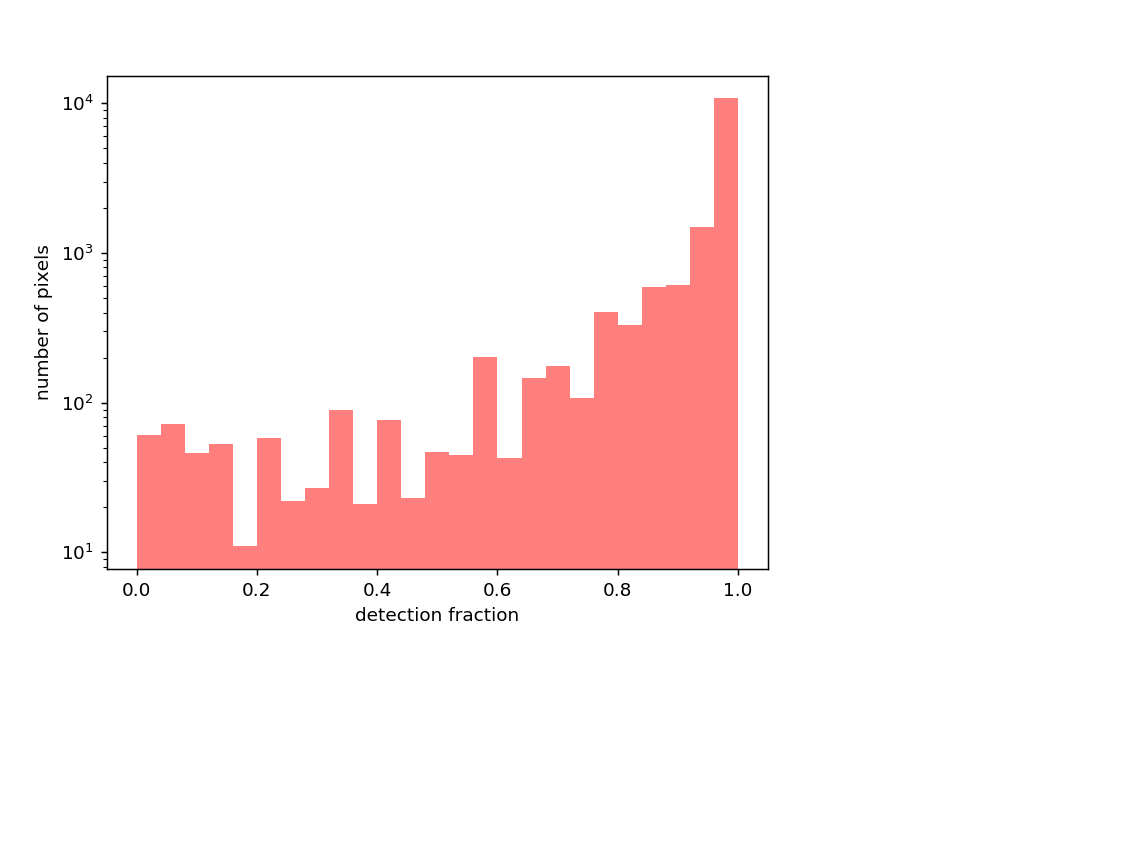

Text(0,0.5,'number of pixels')

In [9]:
fig, axes = plt.subplots()
n, bins, patches = axes.hist(np.array(detfrac), 25, facecolor='red', alpha=0.50, log=True)
axes.set_xlabel('detection fraction')
axes.set_ylabel('number of pixels')

#### Spatial distribution of pixels

<IPython.core.display.Javascript object>


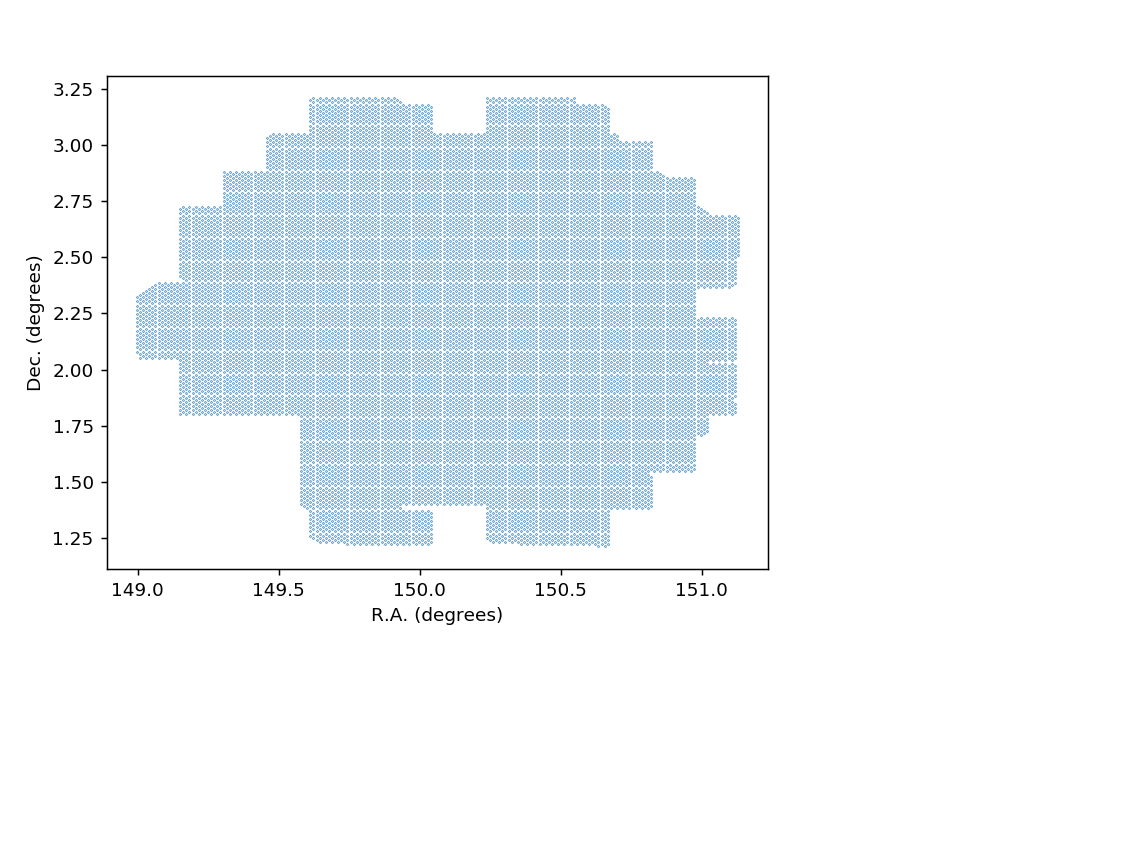

Text(0,0.5,'Dec. (degrees)')

In [10]:
fig, axes = plt.subplots()
axes.scatter(ra, dec, s=.1)
axes.set_xlabel('R.A. (degrees)')
axes.set_ylabel('Dec. (degrees)')

#### Det frac map with color bar

<IPython.core.display.Javascript object>


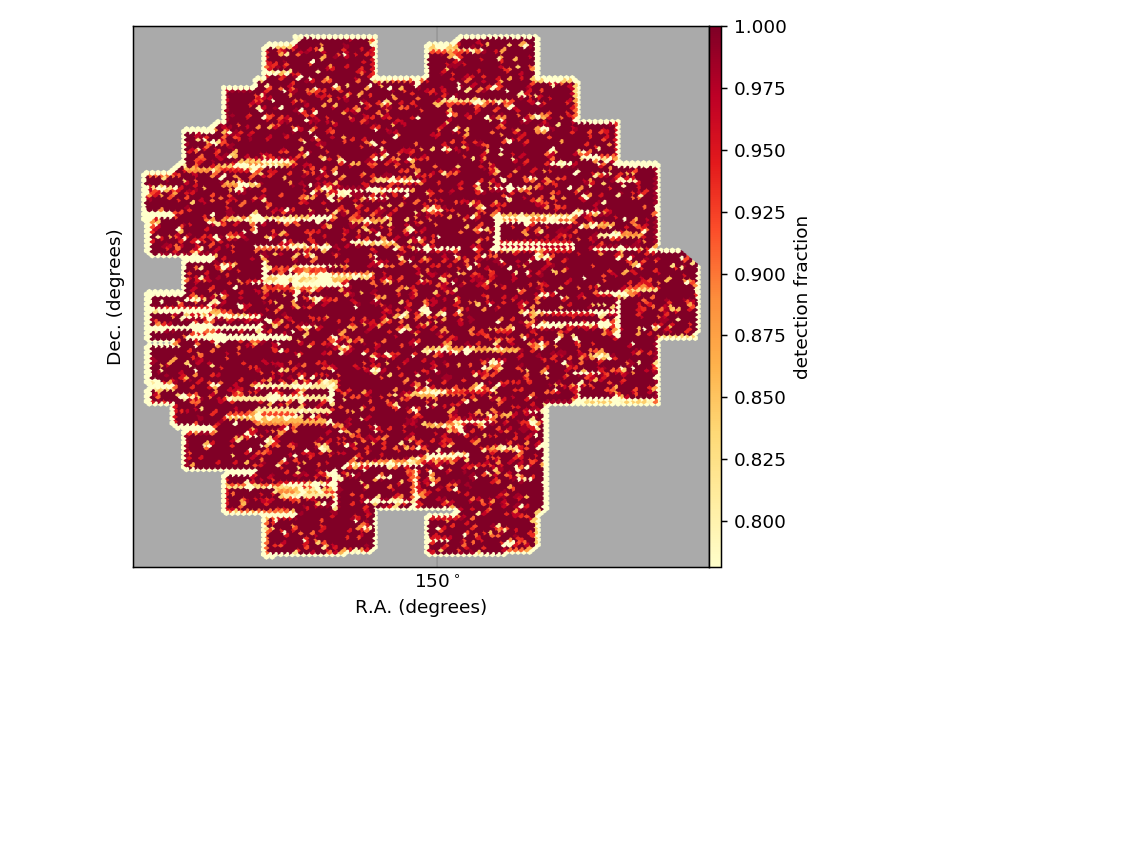

In [11]:
pt.plot_map(np.array([ra, dec, detfrac]).T, label="detection fraction")
plt.tight_layout()

15583


<IPython.core.display.Javascript object>


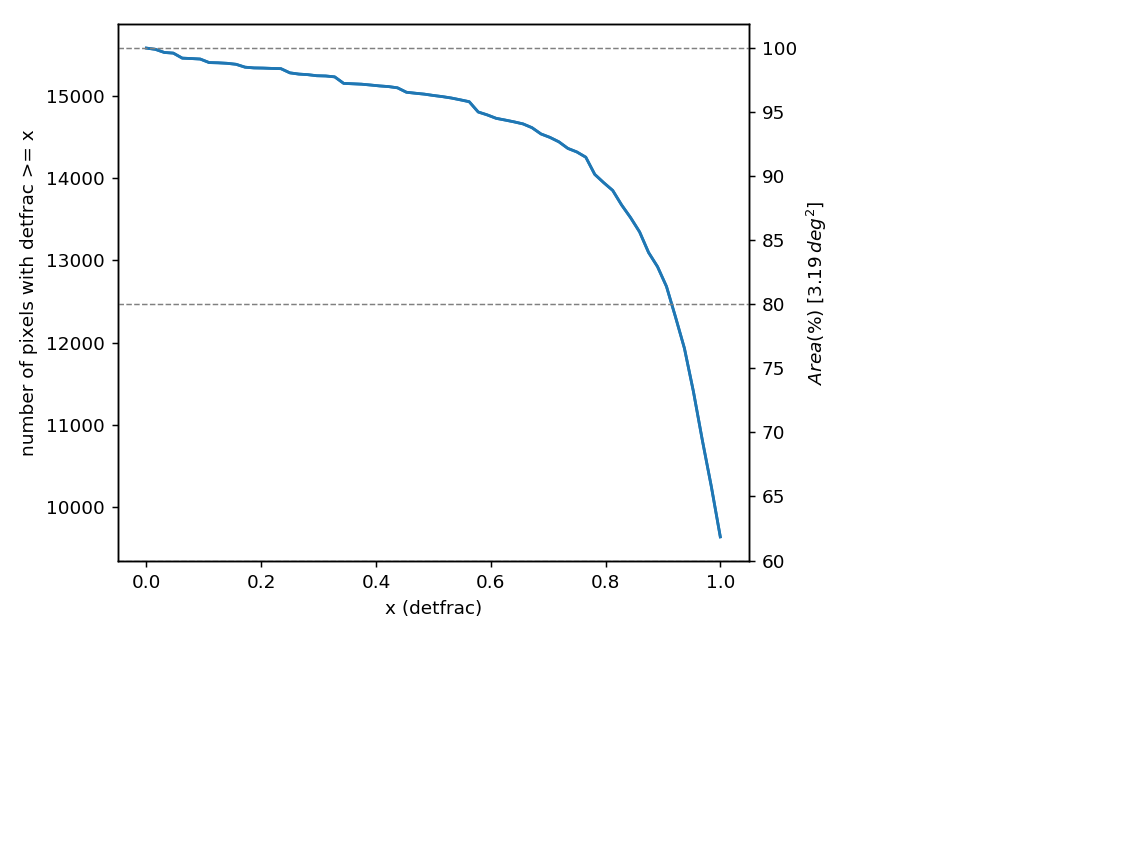

In [13]:
pt.plot_signal_area(np.array(detfrac), NSIDE=4096, xlabel='x (detfrac)', ylabel='number of pixels with detfrac >= x' )

# paramos aqui (Julia e Hillysson)

In [ ]:
input_params = {}
intermediate_tables = {}

input_params['schema'] = 'y1a1_coadd_cosmos_d04'
input_params['table'] = 'mangle_maps_4096_ring_frac_i_10029940'
input_params['signal'] = 0.8

operation = qy1.GreatEqualThanSignalColumn(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_mangle_i')

In [ ]:
original_data = dal.select_columns('mangle_maps_4096_ring_frac_i_10029940', schema='y1a1_coadd_cosmos_d04', columns=['signal'])
filtered_data = dal.select_columns("tmp_table_mangle_i", columns=['signal'])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
n, bins, patches = ax1.hist(np.array(original_data), 25, facecolor='red', alpha=0.50)
ax1.set_xlabel('xlabel')
ax1.set_ylabel('ylabel')

n, bins, patches = ax2.hist(np.array(filtered_data), 25, facecolor='red', alpha=0.50)
ax2.set_xlabel('Xlabel')
ax2.set_ylabel('Ylabel')

fig.show()

In [ ]:
# Surface plots
from src import plots as pt

data = dal.select_columns('tmp_table_mangle_i', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

In [ ]:
input_params = {}
intermediate_tables = {}

input_params['schema'] = 'y1a1_coadd_cosmos_d04'
input_params['table'] = 'mangle_maps_4096_ring_frac_g_10029940'
input_params['signal'] = 0.9

operation = qy1.GreatEqualThanSignalColumn(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_mangle_g')

In [ ]:
data = dal.select_columns("tmp_table_mangle_g", columns=['signal'])

fig, axes = plt.subplots()
n, bins, patches = axes.hist(np.array(data), 25, facecolor='red', alpha=0.50)
axes.set_xlabel('xlabel')
axes.set_ylabel('ylabel')
fig.show()

# Review

* The pixels have different areas. How to combine them?

In [ ]:
input_params = {}
intermediate_tables = {}

intermediate_tables['tables'] = []
intermediate_tables['tables'].append({'schema': dal.schema_output, 'table': 'tmp_table_mangle_i'})
intermediate_tables['tables'].append({'schema': dal.schema_output, 'table': 'tmp_table_mangle_g'})

operation = qy1.CombinedMaps(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_mangle_combined')

In [ ]:
data = dal.select_columns('tmp_table_mangle_combined', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

In [ ]:
table_bad_regions = sqlalchemy.Table("y1a1_coadd_cosmos_d04_bright_mask_4096_ring_10023572", dal.meta, autoload=True, schema="bright_mask").alias('table_bad_regions')
str(table_bad_regions.c.values())

# Review

* nomenclature of maps  
* flag conditions  
* are the maps ingested in the DB correct?

In [ ]:
input_params = {}
intermediate_tables = {}

input_params['schema'] = 'bright_mask'
input_params['table'] = 'y1a1_coadd_cosmos_d04_bright_mask_4096_ring_10023572'

filters = [32, 8, 4, 2]
input_params['filters'] = filters

operation = qy1.BadRegions(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_table_bad_regions')

# Review
* jupyter-vac kernel. What is the skymapper version?

In [ ]:
data = dal.select_columns('tmp_table_bad_regions', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

# Depth Map

In [ ]:
# Add comments.
table_depth_i = sqlalchemy.Table("y1a1_coadd_cosmos_d04_5_auto_4096_ring_i_10024579", dal.meta, autoload=True, schema="depth_maps").alias('table_mangle_i')
str(table_depth_i.c.values())

In [ ]:
# Inspect SQL
stm = sqlalchemy.select([table_depth_i]).where(table_depth_i.c.signal >= 24)
print(sqlparse.format(str(stm), reindent=True, keyword_case='upper'))

In [ ]:
%%time
dal.create_table('tmp_table_depth_i', stm)

In [ ]:
data = dal.select_columns('tmp_table_depth_i', columns=['signal'])

In [ ]:
fig, axes = plt.subplots()
n, bins, patches = axes.hist(np.array(data), 25, facecolor='red', alpha=0.50)
axes.set_xlabel('mlim')
axes.set_ylabel('number of pixels')
fig.show()

In [ ]:
data = dal.select_columns('tmp_table_depth_i', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

In [ ]:
data = dal.select_columns('tmp_table_depth_i', columns=['signal'])
pt.plot_signal_area(data, NSIDE=4096)

# Insert bright mask ?

In [ ]:
# Footprint
input_params = {}
intermediate_tables = {}

intermediate_tables['good_regions'] = []
intermediate_tables['bad_regions'] = []

intermediate_tables['good_regions'].append({'schema': dal.schema_output, 'table': 'tmp_table_depth_i'})
intermediate_tables['good_regions'].append({'schema': dal.schema_output, 'table': 'tmp_table_mangle_i'})
intermediate_tables['bad_regions'].append({'schema': dal.schema_output, 'table': 'tmp_table_bad_regions'})

operation = qy1.Footprint(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_footprint')

In [ ]:
# data = dal.select_columns('tmp_footprint', columns=['signal'])

In [ ]:
data = dal.select_columns('tmp_footprint', columns=['ra', 'dec', 'signal'])
pt.plot_map(data)

# Review

* The reference band to calculate the area

In [ ]:
data = dal.select_columns('tmp_footprint', columns=['signal'])
pt.plot_signal_area(data, NSIDE=4096)

# Step 2 - Object Selection

Reduciton  
Cuts  
Bitmask  
Column selection

In [ ]:
# Zero Point
input_params = {}
intermediate_tables = {}

input_params['zero_point'] = {'schema': 'zeropoint_correction', 'table': 'slr_zeropoints_10023395'}
input_params['coadd_objects'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}

input_params['correction_type'] = 'extinction_and_slr'
input_params['add_slr_shift_columns'] = True
input_params['add_cuts_columns'] = True
input_params['mag_type'] = 'auto'
input_params['columns'] = ["mag_model_g", "mag_model_r", "mag_model_i", "mag_model_z", "mag_model_y", "mag_auto_g", "mag_auto_r", "mag_auto_i", "mag_auto_z", "mag_auto_y"]

operation = qy1.ZeroPoint(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_zero_point')

In [ ]:
# Reduction
input_params = {}
intermediate_tables = {}

input_params['coadd_objects_ring'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects_pixel_4096_ring_10029940'}
intermediate_tables['footprint'] = {'schema': dal.schema_output, 'table': 'tmp_footprint'}

operation = qy1.Reduction(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_reduction')

In [ ]:
# Cuts
input_params = {}
intermediate_tables = {}

input_params['coadd_objects'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}
input_params['mag_type'] = 'auto'
input_params['sextractor_flags'] = [0, 1, 2]
input_params['sextractor_bands'] = ['i']
input_params['additional_cuts'] = ['remove_bbj', 'spreaderr_model', 'bad_astronomic_colors']
input_params['niter_model'] = []
input_params['sn_cuts'] = {}
input_params['magnitude_limit'] = {'i': '22'}
input_params['bright_magnitude'] = {'i': '15'}
input_params['color_cuts'] = {'gr':[-2, 4], 'ri':[-2, 4], 'iz':[-2, 4], 'zy':[-2, 4]}

intermediate_tables['zero_point'] = {'schema': dal.schema_output, 'table': 'tmp_zero_point'}
intermediate_tables['reduction'] = {'schema': dal.schema_output, 'table': 'tmp_reduction'}

operation = qy1.Cuts(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_cuts')

In [ ]:
# rever plot = colunas ra e dec não existentes
# data = dal.select_columns('tmp_cuts', columns=['ra', 'dec'])
# pt.plot_catalog(4096, data)

In [ ]:
# Bitmask
input_params = {}
intermediate_tables = {}

input_params['molygon_coadds'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects_molygon_10029940'}
input_params['molygon'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'molygon_10029940'}
# mangle_bitmask
# g,r,i,z,Y
input_params['mangle_bitmask'] = ['i']

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_cuts'}

operation = qy1.Bitmask(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_bitmask')

In [ ]:
# Object Selection
input_params = {}
intermediate_tables = {}

input_params['coadd_objects'] = {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}
input_params['columns_data_set'] = ['a_image', 'alphawin_j2000_y', 'bwin_image_r', 'chi2_psf_r', 'ra', 'dec']
input_params['columns_zero_point'] = ['mag_model_g', 'mag_model_r', 'mag_auto_z', 'mag_auto_y']

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_bitmask'}
intermediate_tables['zero_point'] = {'schema': dal.schema_output, 'table': 'tmp_zero_point'}

operation = qy1.ObjectSelection(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_object_selection')

In [ ]:
data = dal.select_columns('tmp_object_selection', columns=['ra', 'dec'])
pt.plot_catalog(4096, data)

In [ ]:
# PhotoZ
input_params = {}
intermediate_tables = {}

input_params['zmin'] = 0
input_params['zmax'] = 2
input_params['pz_tables'] = [{'schema': 'photoz_compute', 'table': 'dnf_10027425'}]

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_object_selection'}

operation = qy1.PhotoZ(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_photoz')

In [ ]:
intermediate_tables = {"cur_table": {"schema": dal.schema_output, "table": 'tmp_photoz'},
                      "coadd_objects": {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}}
data = dal.prepare_data_to_plot_catalog(intermediate_tables)
pt.plot_catalog(4096, data)

In [ ]:
# Star Galaxy Separation
input_params = {}
intermediate_tables = {}

input_params['select_starts'] = True
input_params['select_galaxies'] = False
input_params['reference_band'] = 'g'
input_params['sg_tables'] = [{'schema': 'sg_separation', 'table': 'modest_10022759'}]

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_photoz'}

operation = qy1.SgSeparation(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_sg_separation')

In [ ]:
intermediate_tables = {"cur_table": {"schema": dal.schema_output, "table": 'tmp_sg_separation'},
                      "coadd_objects": {'schema': 'y1a1_coadd_cosmos_d04', 'table': 'coadd_objects'}}
data = dal.prepare_data_to_plot_catalog(intermediate_tables)
pt.plot_catalog(4096, data)

In [ ]:
# Galaxy Properties - only add additional columns at the end of the table.
input_params = {}
intermediate_tables = {}

input_params['columns'] = ["mod_best", "ebv_best", "k_cor_g", "k_cor_i", "k_cor_r", "k_cor_y", "k_cor_z", "mag_abs_g", "mag_abs_i", "mag_abs_r", "mag_abs_y", "mag_abs_z", "mass_best", "age_best", "sfr_best"]
input_params['gp_tables'] = [{'schema': 'gal_properties', 'table': 'lephare_10022885'}]

intermediate_tables['last_table'] = {'schema': dal.schema_output, 'table': 'tmp_sg_separation'}

operation = qy1.GalaxyProperties(dal, input_params, intermediate_tables)
print(sqlparse.format(operation.sql(), reindent=True, keyword_case='upper'))

In [ ]:
%%time
operation.create_table('tmp_galaxy_properties')